In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

    Supports vector inputs (x) and vector outputs (y). Kernel is
    mean-squared exponential, using the x-value l2 coordinate distance scaled by
    some factor chosen randomly in a range. Outputs are independent gaussian
    processes.
    """

    def __init__(
        self,
        batch_size,
        max_num_context,
        x_size=1,
        y_size=1,
        l1_scale=0.4,
        sigma_scale=1.0,
        testing=False,
    ):
        """Creates a regression dataset of functions sampled from a GP.

        Args:
          batch_size: An integer.
          max_num_context: The max number of observations in the context.
          x_size: Integer >= 1 for length of "x values" vector.
          y_size: Integer >= 1 for length of "y values" vector.
          l1_scale: Float; typical scale for kernel distance function.
          sigma_scale: Float; typical scale for variance.
          testing: Boolean that indicates whether we are testing. If so there are
              more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

        Args:
          xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
              the values of the x-axis data.
          l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
              parameter of the Gaussian kernel.
          sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
              of the std.
          sigma_noise: Float, std of the noise that we add for stability.

        Returns:
          The kernel, a float tensor with shape
          `[batch_size, y_size, num_total_points, num_total_points]`.
        """
        num_total_points = xdata.shape[1]

        # Expand and take the difference
        x1 = xdata.unsqueeze(dim=1)
        x2 = xdata.unsqueeze(dim=2)

        diff = x1 - x2  # [B, num_total_points, num_total_points, x_size]

        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :]) ** 2

        norm = norm.sum(dim=-1)  # [B, data_size, num_total_points, num_total_points]

        # [B, y_size, num_total_points, num_total_points]
        kernel = (sigma_f ** 2)[:, :, None, None] * torch.exp(-0.5 * norm)

        # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise ** 2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

        Generated functions are `float32` with x values between -2 and 2.

        Returns:
          A `CNPRegressionDescription` namedtuple.
        """

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        # If we are testing we want to have more targets and have them evenly
        # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target)
            x_values = (
                x_values.unsqueeze(dim=0).repeat([self._batch_size, 1]).unsqueeze(-1)
            )

        # During training the number of target points and their x-positions are
        # selected at random
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (
                torch.rand((self._batch_size, num_total_points, self._x_size)) * 4 - 2
            )  # unif[-2, 2]

        # Set kernel parameters
        l1 = torch.ones(self._batch_size, self._y_size, self._x_size) * self._l1_scale
        sigma_f = torch.ones(self._batch_size, self._y_size) * self._sigma_scale

        # Pass the x_values through the Gaussian kernel
        # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

        # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel.type(torch.DoubleTensor)).type(
            torch.FloatTensor
        )

        # Sample a curve
        # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(
            cholesky, torch.randn(self._batch_size, self._y_size, num_total_points, 1)
        )

        # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3).permute([0, 2, 1])

        if self._testing:
            # Select the targets
            target_x = x_values
            target_y = y_values

            # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]

        else:
            # Select the targets which will consist of the context points as well as
            # some new target points
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]

            # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return CNPRegressionDescription(query=query, target_y=target_y)


class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation

        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1

        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation


class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        """
        Take representation representation of current training set, and a target input x,
        return the probability of x being positive

        Args:
            representation: batch_size x representation_size
            target_x: batch_size x set_size x d
        """
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma


class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma


def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the predicted mean and variance and the context points.

    Args:
      target_x: An array of shape batchsize x number_targets x 1 that contains the
          x values of the target points.
      target_y: An array of shape batchsize x number_targets x 1 that contains the
          y values of the target points.
      context_x: An array of shape batchsize x number_context x 1 that contains
          the x values of the context points.
      context_y: An array of shape batchsize x number_context x 1 that contains
          the y values of the context points.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted means of the y values at the target points in target_x.
      pred_y: An array of shape batchsize x number_targets x 1  that contains the
          predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], "b", linewidth=2)
    plt.plot(target_x[0], target_y[0], "k:", linewidth=2)
    plt.plot(context_x[0], context_y[0], "ko", markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
    )

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid(False)
    # ax = plt.gca()
    # ax.set_axis_bgcolor('white')
    plt.show()

2020-04-06 23:54:14, Iteration: 0, test loss: 1.6164302825927734


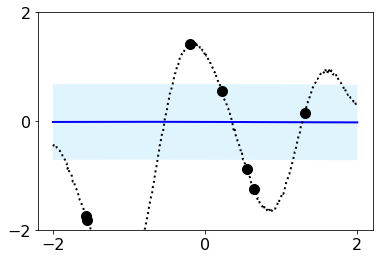

2020-04-06 23:57:22, Iteration: 20000, test loss: 1.0075548887252808


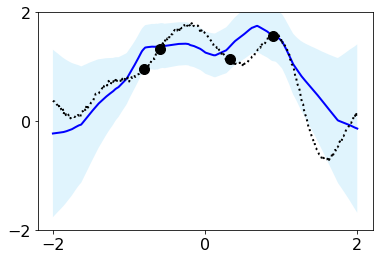

2020-04-07 00:00:29, Iteration: 40000, test loss: 1.3116708993911743


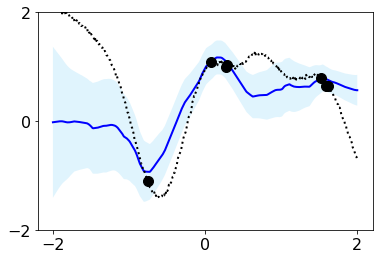

2020-04-07 00:03:45, Iteration: 60000, test loss: 0.9712738394737244


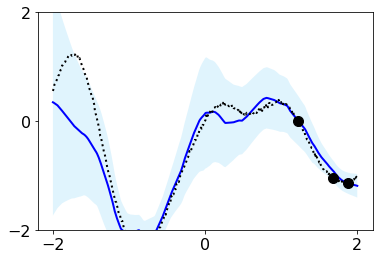

2020-04-07 00:07:11, Iteration: 80000, test loss: 0.5483538508415222


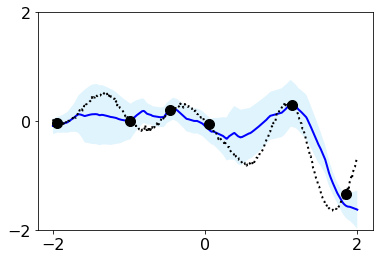

2020-04-07 00:10:25, Iteration: 100000, test loss: 0.6503702998161316


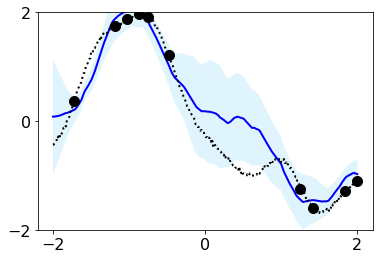

2020-04-07 00:13:33, Iteration: 120000, test loss: 0.40350502729415894


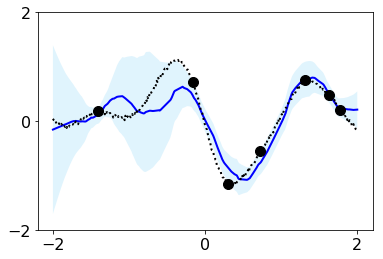

2020-04-07 00:16:41, Iteration: 140000, test loss: 0.5805412530899048


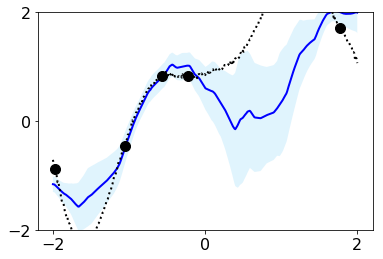

2020-04-07 00:19:53, Iteration: 160000, test loss: 0.6913691759109497


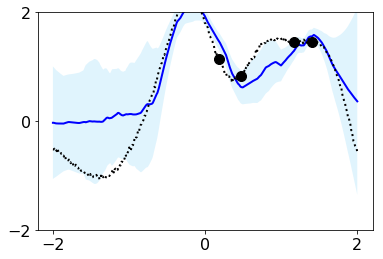

2020-04-07 00:22:55, Iteration: 180000, test loss: 0.646782636642456


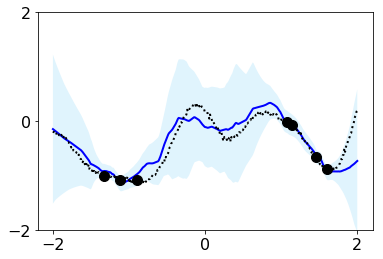

In [2]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
MAX_CONTEXT_POINTS = 10
torch.manual_seed(0)
# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]

model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for it in range(TRAINING_ITERATIONS):
    data_train = dataset_train.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()
    # print('Iteration: {}, train loss: {}'.format(it, loss))
    if it % PLOT_AFTER == 0:
        data_test = dataset_test.generate_curves()
        test_log_prob, pred_y, var = model(data_test.query, data_test.target_y)
        test_loss = -test_log_prob.mean()
        

        print("{}, Iteration: {}, test loss: {}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss)
        )
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
        )